*Disclaimer: This work is a giant pile of scratch work, and is not very organized.*

# Notes
- My models appear to be okay, but my preprocessing still leaves something to be desired.
- With my method of preprocessing, I am able to get close to 0.80 accuracy with random forests, but I am routinely around 0.70 on SVC despite assertions everywhere that SVC should get me past 0.80.
- I tried preprocessing code from https://www.kaggle.com/sinakhorami/titanic-best-working-classifier but was still only around 0.78 on Kaggle.

In [374]:
#!/usr/bin/env python

# (c) 2017, Chris Hodapp
# Code for: https://www.kaggle.com/c/titanic

# "It is your job to predict if a passenger survived the sinking of
# the Titanic or not. For each PassengerId in the test set, you must
# predict a 0 or 1 value for the Survived variable."  "Your score is
# the percentage of passengers you correctly predict."

import pandas
import matplotlib
import matplotlib.pyplot as plt
import numpy
import xgboost
import sklearn
import sklearn.model_selection
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.svm

In [382]:
import sinakhorami_preprocess

/home/hodapp/source/kaggle-titanic/sinakhorami_preprocess.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list


In [387]:
pandas.set_option("display.width", None)

# Load data:
train_raw = pandas.read_csv("train.csv")
test = pandas.read_csv("test.csv")

# Transform some columns:
def getprefix(name):
    return [pt[:-1] for pt in name.split(" ") if pt.endswith(".")][0]
def xform_input(df):
    # One-hot encode categorical Embarked column
    # Turn column "Sex" to a number - 0 for male, 1 for female
    # (it has only these two categories, all non-null)
    # Extract first letter of Cabin and one-hot encode
    # Extract title (Mr, Mrs, Mme, Captain, etc.) from Title, one-hot encode
    onehot_emb = pandas.get_dummies(df.Embarked, "Embarked")
    onehot_cabin = pandas.get_dummies([i[0] for i in df.Cabin.fillna("N")], "Cabin")
    onehot_title = pandas.get_dummies([getprefix(n) for n in train.Name if "." in n], "Title")
    counts = train_raw.groupby("Ticket", as_index=False).size().reset_index(name="Count")
    df2 = train_raw.merge(counts, on="Ticket")
    return df.assign(Sex = numpy.where(df.Sex == "male", 0, 1)) \
             .assign(FarePer = df2.Fare / df2.Count) \
             .assign(Alone = ((df2.SibSp + df2.Parch) == 0)) \
             .drop("Embarked", axis=1) \
             .drop("Cabin", axis=1) \
             .join(onehot_cabin) \
             .join(onehot_emb) \
             .join(onehot_title)

# Select columns (prefix_cols grabs entire group by prefix):
prefix_cols = ["Embarked", "Title"] # "Cabin"
def matches_prefix(col):
    for p in prefix_cols:
        if col.startswith(p): return True
    return False
cols = ["Sex", "Age", "Fare", "SibSp", "Parch"] + \
    [i for i in train.columns if matches_prefix(i)]
# ["FarePer", "Count", "Pclass"] \
train = xform_input(train_raw)
train_X = train.loc[:, cols]
train_Y = train.loc[:, "Survived"]
test = xform_input(test)

# Fill in NAs:
imp = sklearn.preprocessing.Imputer(strategy = "mean", axis = 0)
imp = imp.fit(train_X)
train_X_arr = imp.transform(train_X)
test_X_arr = imp.transform(test.loc[:, cols])

In [397]:
# Make a zoo of models to test:
logistic = sklearn.linear_model.LogisticRegression(C = 1e5)
rf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100, criterion="entropy", max_depth=5, n_jobs=-1,
    random_state=12348)
rf2 = sklearn.ensemble.RandomForestClassifier(
    n_estimators=2000, criterion="entropy", max_depth=5, n_jobs=-1,
    random_state=12348)
rf3 = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100, criterion="entropy", max_depth=10, n_jobs=-1,
    random_state=12348)
rf4 = sklearn.ensemble.RandomForestClassifier(
    n_estimators=2000, criterion="entropy", max_depth=10, n_jobs=-1,
    random_state=12348)
ab = sklearn.ensemble.AdaBoostClassifier(
    n_estimators=400,
    learning_rate=1.0,
    random_state=12345)
svc = sklearn.svm.SVC()
xgb = xgboost.sklearn.XGBClassifier(nthread=-1, seed=12345)

models = {
    "Logistic regression": logistic,
    "Random forest(100,5)": rf,
    "Random forest(2000,5)": rf2,
    "Random forest(100,10)": rf3,
    "Random forest(2000,10)": rf4,
    "AdaBoost": ab,
    "SVC": svc,
    "XGBoost": xgb
}

In [398]:
# Training & validation accuracy (my models, but sinakhorami's preprocessed data):
def echo_accuracy(model, name):
    scores = sklearn.model_selection.cross_val_score(
        model,
        sinakhorami_preprocess.train[:,1::], #train_X_arr,
        sinakhorami_preprocess.train[:,0],  #train_Y,
        cv=sklearn.model_selection.StratifiedShuffleSplit())
    print("{0}, accuracy: {1:.3f} (+/- {2:.3f})".format(name, scores.mean(), scores.std() * 2))

for name in models:
    echo_accuracy(models[name], name)
#echo_accuracy(rf, "Random Forest")
#echo_accuracy(xgb, "XGBoost")

AdaBoost, accuracy: 0.800 (+/- 0.074)
Random forest(100,10), accuracy: 0.812 (+/- 0.047)
XGBoost, accuracy: 0.828 (+/- 0.076)
Random forest(100,5), accuracy: 0.818 (+/- 0.064)
Random forest(2000,10), accuracy: 0.831 (+/- 0.051)
Random forest(2000,5), accuracy: 0.808 (+/- 0.077)
Logistic regression, accuracy: 0.802 (+/- 0.084)
SVC, accuracy: 0.833 (+/- 0.062)


In [399]:
# Training & validation accuracy:
def echo_accuracy(model, name):
    scores = sklearn.model_selection.cross_val_score(
        model,
        train_X_arr,
        train_Y,
        cv=sklearn.model_selection.StratifiedShuffleSplit())
    print("{0}, accuracy: {1:.3f} (+/- {2:.3f})".format(name, scores.mean(), scores.std() * 2))

for name in models:
    echo_accuracy(models[name], name)
#echo_accuracy(rf, "Random Forest")
#echo_accuracy(xgb, "XGBoost")

AdaBoost, accuracy: 0.799 (+/- 0.084)
Random forest(100,10), accuracy: 0.813 (+/- 0.068)
XGBoost, accuracy: 0.814 (+/- 0.084)
Random forest(100,5), accuracy: 0.831 (+/- 0.067)
Random forest(2000,10), accuracy: 0.834 (+/- 0.095)
Random forest(2000,5), accuracy: 0.830 (+/- 0.063)
Logistic regression, accuracy: 0.828 (+/- 0.056)
SVC, accuracy: 0.747 (+/- 0.074)


In [403]:
# Generate submission:
model = sklearn.ensemble.RandomForestClassifier(
    n_estimators=10000, criterion="entropy", max_depth=10, n_jobs=-1)
#model = sklearn.svm.SVC()
#model.fit(sinakhorami_preprocess.train[:,1::],
#          sinakhorami_preprocess.train[:,0],
#         )
model.fit(train_X_arr, train_Y)
submission = test[["PassengerId"]]
#submission = submission.assign(Survived = model.predict(sinakhorami_preprocess.test))
submission = submission.assign(Survived = model.predict(test_X_arr))
submission.to_csv("submission.csv", index=False)

In [404]:
echo_accuracy(model, "submission model")

submission model, accuracy: 0.834 (+/- 0.057)


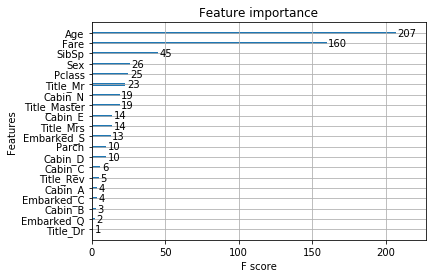

In [343]:
%matplotlib inline
matplotlib.pyplot.figure()
xgb.fit(train_X, train_Y)
xgboost.plot_importance(xgb, ax=matplotlib.pyplot.gca())

In [344]:
def plot_validation(train_scores, test_scores, param_range):
    # Code adapted from:
    # http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
    train_scores_mean = numpy.mean(train_scores, axis=1)
    train_scores_std = numpy.std(train_scores, axis=1)
    test_scores_mean = numpy.mean(test_scores, axis=1)
    test_scores_std = numpy.std(test_scores, axis=1)
    plt.ylabel("Score")
    #plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

## SVM validation curves

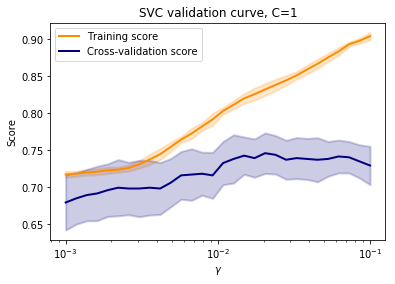

In [356]:
rng = numpy.logspace(-3, -1, 30)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    sklearn.svm.SVC(C=1, probability=True), train_X_arr, train_Y,
    "gamma", rng, cv=sklearn.model_selection.StratifiedShuffleSplit())
plt.title("SVC validation curve, C=1")
plt.xlabel("$\gamma$")
plot_validation(train_scores, valid_scores, rng)

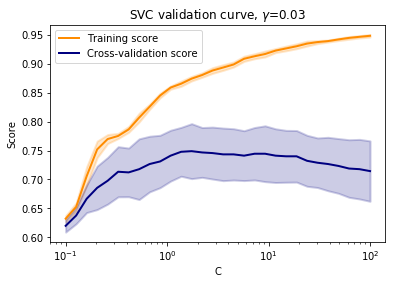

In [357]:
rng = numpy.logspace(-1, 2, 30)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    sklearn.svm.SVC(gamma=0.03, probability=True), train_X_arr, train_Y,
    "C", rng, cv=sklearn.model_selection.StratifiedShuffleSplit())
plt.title("SVC validation curve, $\gamma$=0.03")
plt.xlabel("C")
plot_validation(train_scores, valid_scores, rng)

## xgboost experimentation

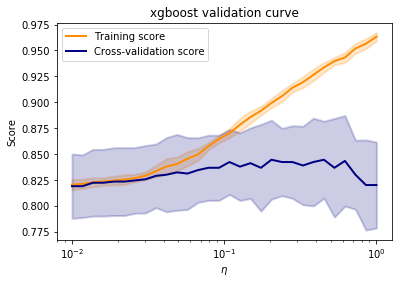

In [418]:
xgb = xgboost.sklearn.XGBClassifier(nthread=-1, seed=12345)
rng = numpy.logspace(-2, 0, 30)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    xgb, train_X_arr, train_Y,
    "learning_rate", rng, cv=sklearn.model_selection.StratifiedShuffleSplit())
plt.title("xgboost validation curve")
plt.xlabel("$\eta$")
plot_validation(train_scores, valid_scores, rng)

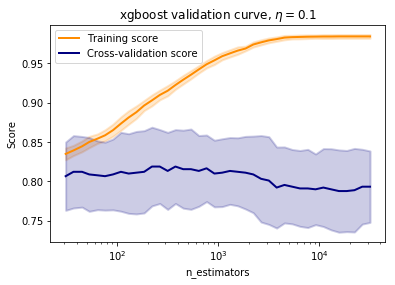

In [423]:
xgb = xgboost.sklearn.XGBClassifier(nthread=-1, seed=12345, learning_rate=0.1)
rng = numpy.logspace(1.5, 3.5, 30).astype(numpy.int64)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    xgb, train_X_arr, train_Y,
    "n_estimators", rng, cv=sklearn.model_selection.StratifiedShuffleSplit())
plt.title("xgboost validation curve, $\eta=0.1$")
plt.xlabel("n_estimators")
plot_validation(train_scores, valid_scores, rng)

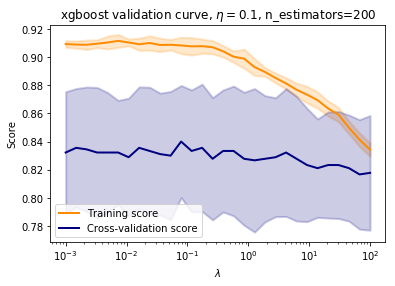

In [422]:
xgb = xgboost.sklearn.XGBClassifier(nthread=-1, seed=12345, learning_rate=0.1, n_estimators=200)
rng = numpy.logspace(-3, 2, 30)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    xgb, train_X_arr, train_Y,
    "reg_lambda", rng, cv=sklearn.model_selection.StratifiedShuffleSplit())
plt.title("xgboost validation curve, $\eta=0.1$, n_estimators=200")
plt.xlabel("$\lambda$")
plot_validation(train_scores, valid_scores, rng)